In [ ]:
import numpy as np
import pandas as pd


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller



<ipython-input-2-14aafe6f608b>:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df= pd.read_csv('/content/HCHO_Emissions_to_model.csv', sep=',', parse_dates=['Start_date'], index_col='Start_date',date_parser=dateparse)


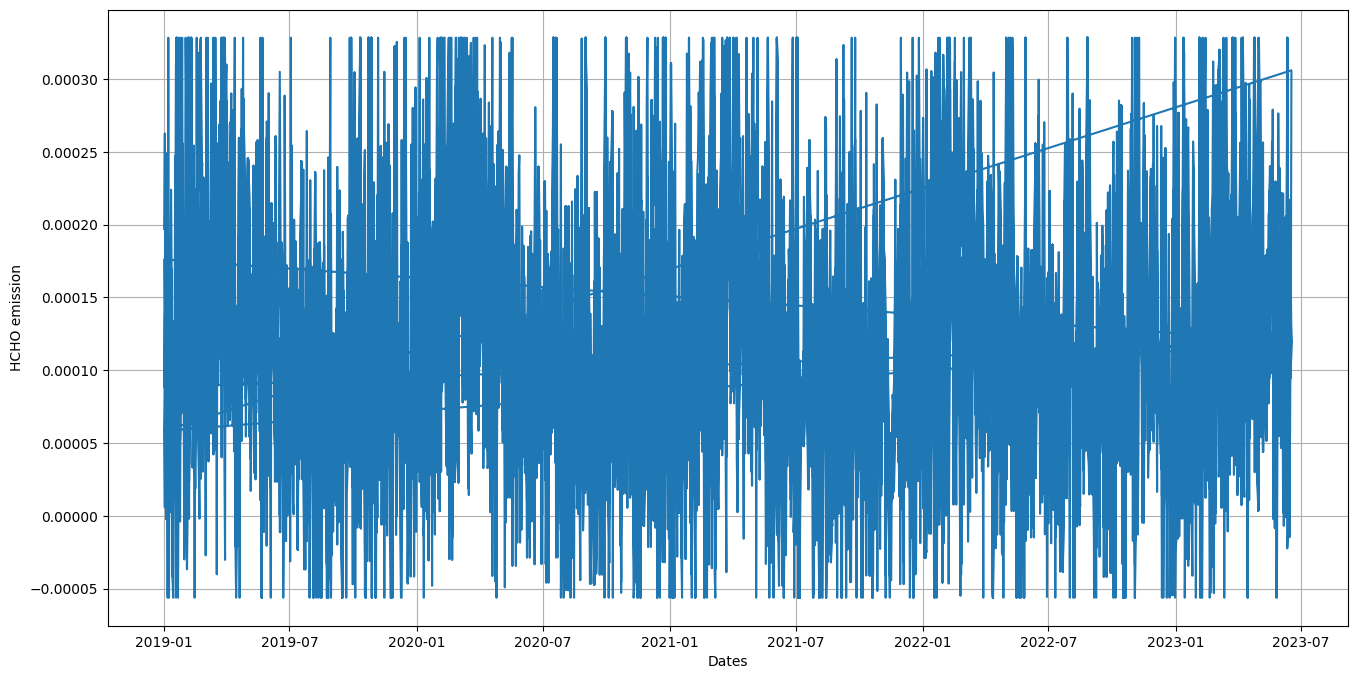

In [ ]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')

df= pd.read_csv('/content/HCHO_Emissions_to_model.csv', sep=',', parse_dates=['Start_date'], index_col='Start_date',date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('HCHO emission')
plt.plot(df['HCHO_Column_Number_Density']);


In [ ]:

cities = df['City'].unique()

# Create a dictionary to store each city's DataFrame
city_dfs = {city: df[df['City'] == city] for city in cities}


# If you want to work with these as separate variables, you can also do this:
city1_df, city2_df, city3_df, city4_df ,city5_df= [city_dfs[city] for city in cities]


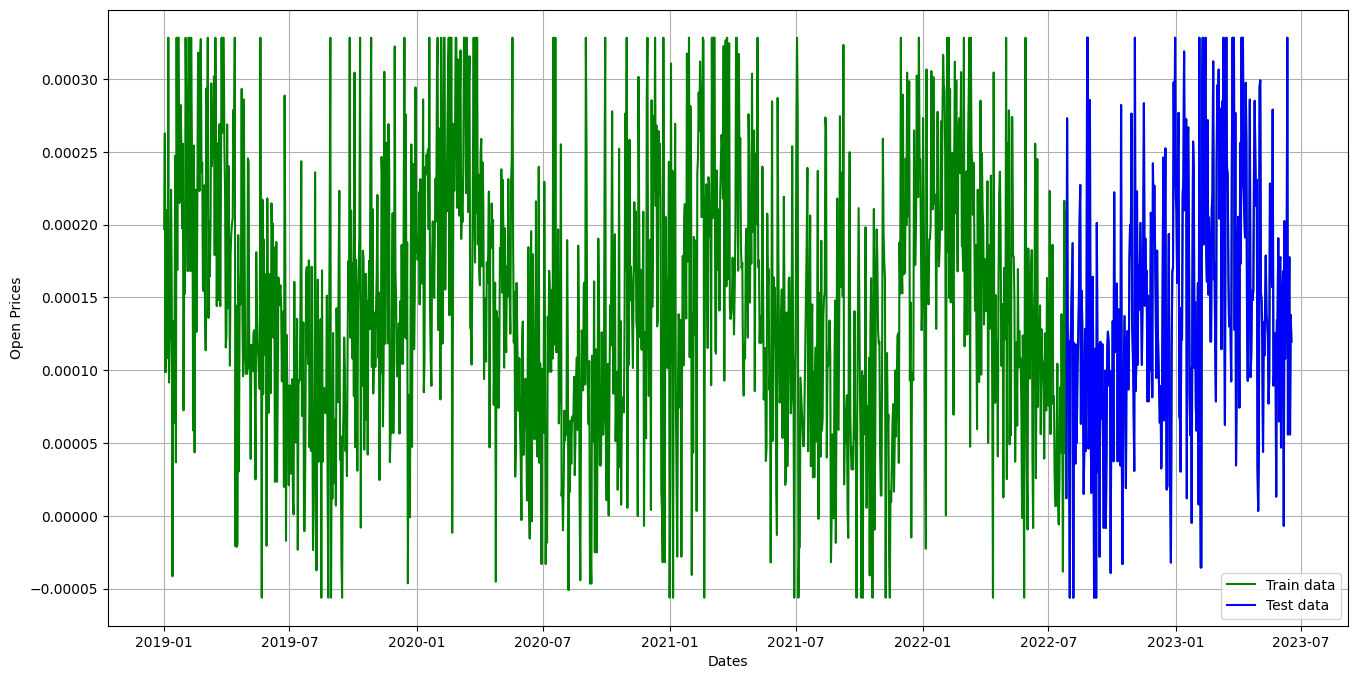

In [ ]:
train_data, test_data = city1_df[0:int(len(city1_df)*0.8)], city1_df[int(len(city1_df)*0.8):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(city1_df['HCHO_Column_Number_Density'], 'green', label='Train data')
plt.plot(test_data['HCHO_Column_Number_Density'], 'blue', label='Test data')
plt.legend()

In [ ]:
city1_df.shape

(1629, 13)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


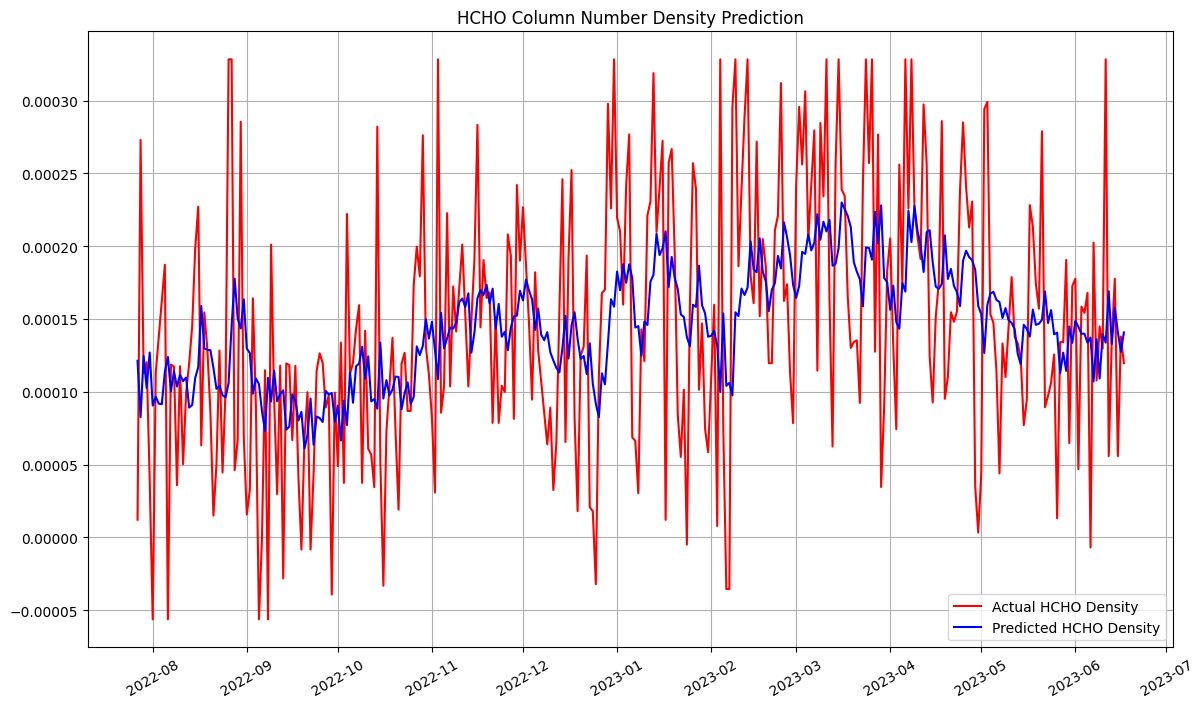

MSE: 6.741647972299599e-09
MAE: 6.570991292766797e-05
RMSE: 8.210753907102319e-05


In [ ]:


train_ar = train_data['HCHO_Column_Number_Density']
test_ar = test_data['HCHO_Column_Number_Density']

# Train autoregression
lags = 15
model = AutoReg(train_ar, lags=lags)
model_fit = model.fit()

# Walk forward over time steps in test
history = train_ar[len(train_ar)-lags:].tolist()
predictions = []
for t in range(len(test_ar)):
    lag = history[-lags:]
    yhat = model_fit.params[0] + sum(model_fit.params[i+1] * lag[lags-i-1] for i in range(lags))
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(test_data.index, test_data['HCHO_Column_Number_Density'], color='red', label='Actual HCHO Density')
plt.plot(test_data.index, predictions, color='blue', label='Predicted HCHO Density')
plt.title('HCHO Column Number Density Prediction')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.show()

# Error metrics
mse = mean_squared_error(test_data['HCHO_Column_Number_Density'], predictions)
mae = mean_absolute_error(test_data['HCHO_Column_Number_Density'], predictions)
rmse = math.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')



In [ ]:
# Inverse differencing function
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Function to perform differencing
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


# Determine the order of differencing (d) needed by looking at the results of the Dickey-Fuller test
result = adfuller(train_ar.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


differenced = difference(train_ar.values)

# Fit an ARIMA model to the differenced data
p, d, q = 2, 0, 2
model = ARIMA(differenced, order=(p, d, q))
model_fit = model.fit()

# Forecast
#reverse the differencing after forecasting
forecasts = model_fit.forecast(steps=len(test_ar))

# Convert to the same scale
history = [x for x in train_ar]
day = 1
for yhat in forecasts:
    inverted = inverse_difference(history, yhat, len(test_ar)+1-day)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1




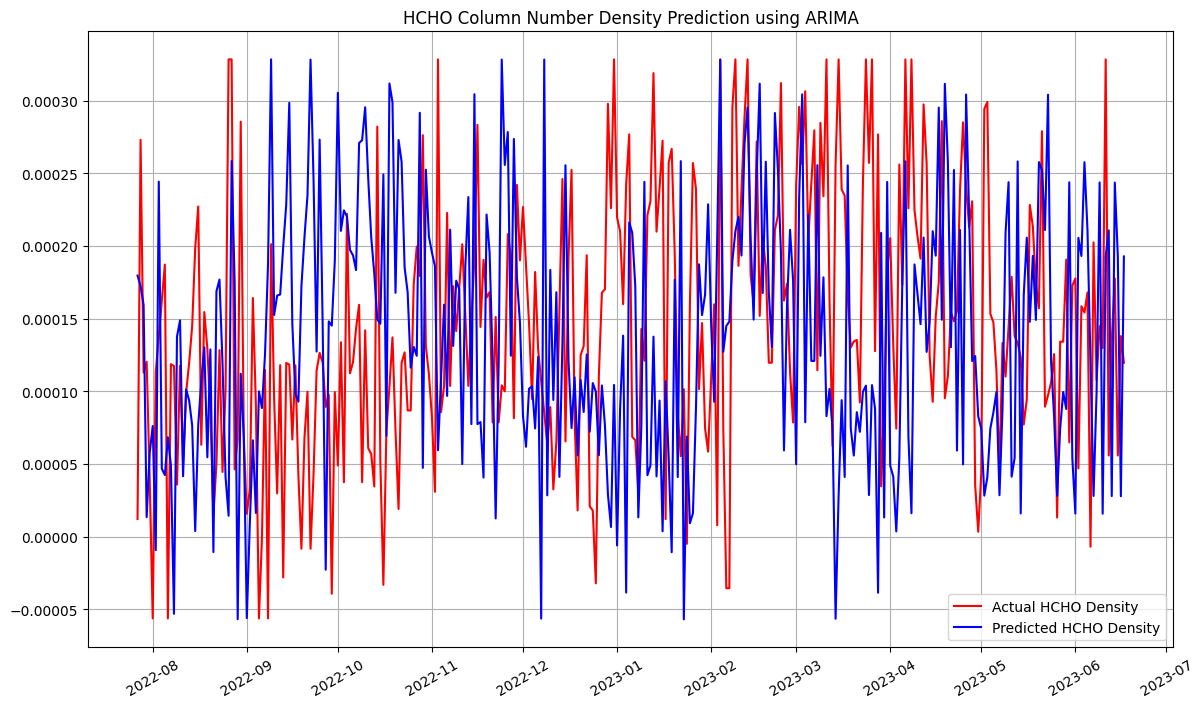

MSE: 1.6854435182094848e-08
MAE: 0.0001072088939941393
RMSE: 0.00012982463241655972


In [ ]:

# Inverse differencing function
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# 'forecasts' are the forecasted values from the differenced ARIMA model

# Reconstruct the forecasted values on the original scale
inverted_forecasts = []
history = train_ar.tolist()  # make sure to convert to a list, if it's not already

for i in range(len(forecasts)):
    # invert the differencing
    yhat_inverted = inverse_difference(history, forecasts[i], len(test_ar)+1-i)
    # store the forecast
    inverted_forecasts.append(yhat_inverted)
    # update the history for the next step
    history.append(yhat_inverted)

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(test_ar.index, test_ar, color='red', label='Actual HCHO Density')
plt.plot(test_ar.index, inverted_forecasts, color='blue', label='Predicted HCHO Density')
plt.title('HCHO Column Number Density Prediction using ARIMA')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.show()

# Error metrics calculation
mse = mean_squared_error(test_ar, inverted_forecasts)
mae = mean_absolute_error(test_ar, inverted_forecasts)
rmse = math.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


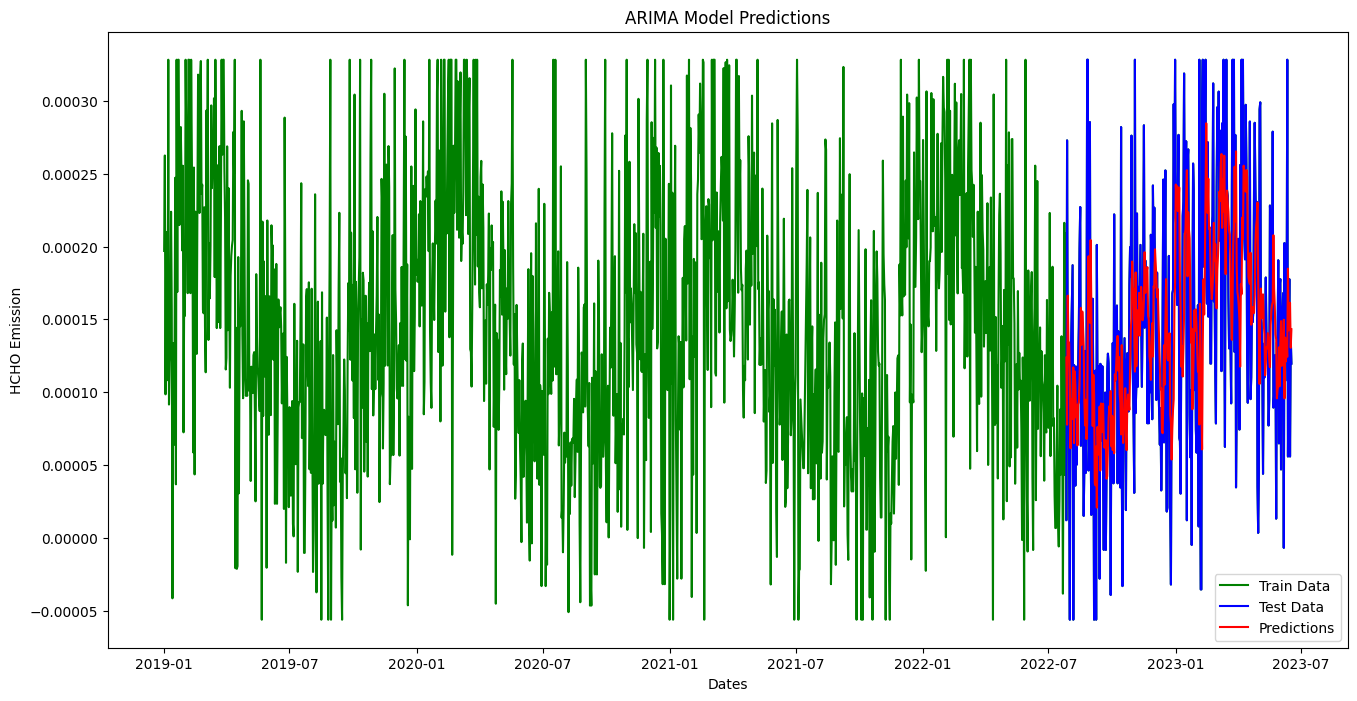

Mean Squared Error: 7.834496635003652e-09


In [ ]:

# Define a function to fit ARIMA model
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    fitted_model = model.fit()
    return fitted_model

# Define a function to make predictions
def make_predictions(model, start, end):
    predictions = model.predict(start=start, end=end)
    return predictions

# Choose the order for ARIMA model
order = (5, 1, 0)

# Train ARIMA model for city1_df
train_data = city1_df['HCHO_Column_Number_Density']
model = fit_arima(train_data, order)

# Make predictions
test_data = city1_df['HCHO_Column_Number_Density'][-len(test_data):]
start_date = test_data.index[0]
end_date = test_data.index[-1]
predictions = make_predictions(model, start_date, end_date)

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(train_data, color='green', label='Train Data')
plt.plot(test_data, color='blue', label='Test Data')
plt.plot(predictions, color='red', label='Predictions')
plt.xlabel('Dates')
plt.ylabel('HCHO Emission')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

# Evaluate model
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error: {mse}")


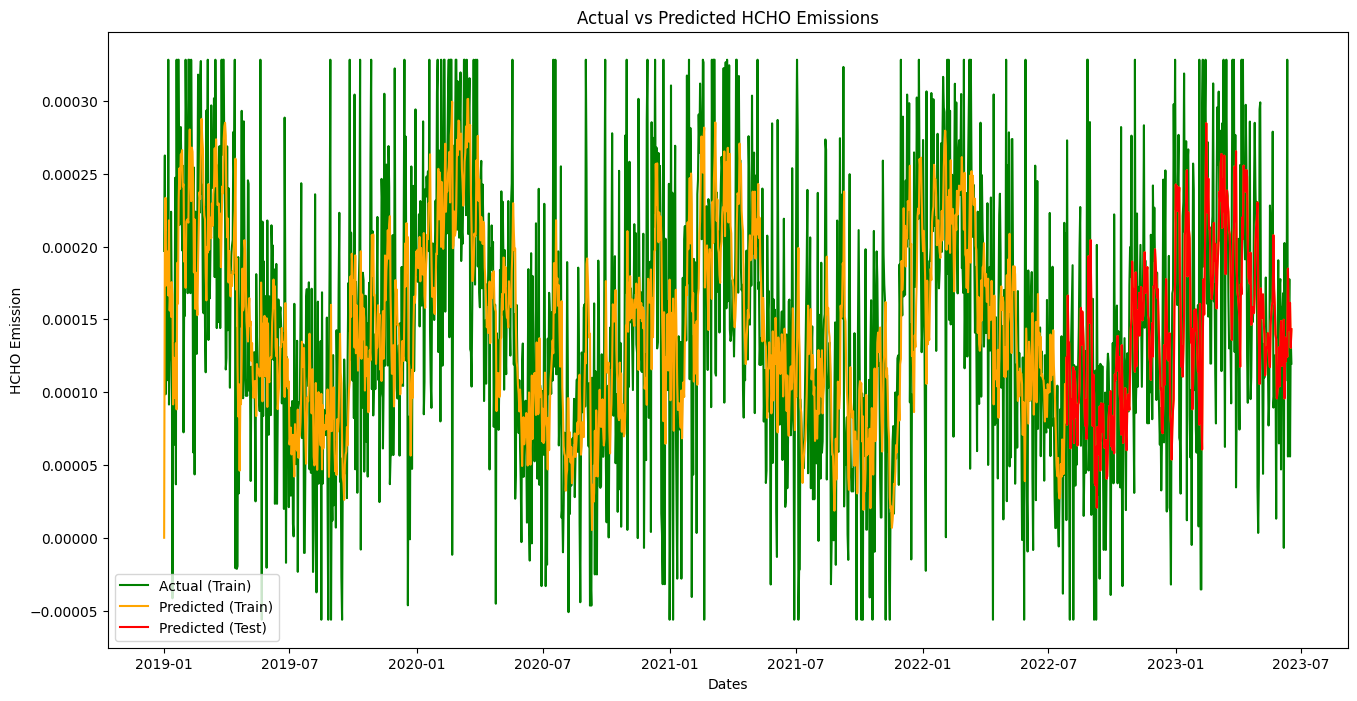

In [ ]:

# Make predictions for training data
train_start_date = train_data.index[0]
train_end_date = train_data.index[-1]
train_predictions = make_predictions(model, train_start_date, train_end_date)

# Make predictions for test data
test_data = city1_df['HCHO_Column_Number_Density'][-len(test_data):]  # Assuming test_data is defined as in the provided code
test_start_date = test_data.index[0]
test_end_date = test_data.index[-1]
test_predictions = make_predictions(model, test_start_date, test_end_date)

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(train_data, color='green', label='Actual (Train)')
plt.plot(train_predictions, color='orange', label='Predicted (Train)')
plt.plot(test_predictions, color='red', label='Predicted (Test)')
plt.xlabel('Dates')
plt.ylabel('HCHO Emission')
plt.title('Actual vs Predicted HCHO Emissions')
plt.legend()
plt.show()

In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 7.834496635003652e-09
Mean Absolute Error (MAE): 7.042033494487229e-05
Root Mean Squared Error (RMSE): 8.851269194304086e-05
